<a href="https://www.kaggle.com/code/ameniayedi/s6e1-predicting-student-test-scores?scriptVersionId=291322958" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color: #B7A6C9; padding:30px; border-radius:50px">
  <h1 style="color:#000000; text-align:center;"> 📚  Predicting Student Test Scores 📚 </h1>
</div>

# 🚧 🚧 🚧 🚧 🚧 🚧 (Still Under Construction) 🚧 🚧 🚧 🚧 🚧 🚧 

The goal of this notebook is to predict students' test scores based on multiple features from the dataset:
* Hours slept, study hours, class attendences..
* Exam difficulty, facility ratings, sleep quality..

The submissions for this competition are evaluated using **Root Mean Squared Error (RMSE)** :
<p style="text-align: center;">
  <img src="https://images.squarespace-cdn.com/content/v1/58c95854c534a56689231265/1531151917631-MP881P65V9DJT0D4G0X9/Figura0.jpg"  width="600"/>
</p>

# 1. Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore")

RAND_STATE=42

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


# 2. Loading Data

In [2]:
train_df=pd.read_csv("/kaggle/input/playground-series-s6e1/train.csv")
test_df=pd.read_csv("/kaggle/input/playground-series-s6e1/test.csv")
ss_df=pd.read_csv("/kaggle/input/playground-series-s6e1/sample_submission.csv")

In [3]:
train_df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [4]:
test_df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [5]:
ss_df.head()

,id,exam_score
0,630000,0
1,630001,0
2,630002,0
3,630003,0
4,630004,0


In [6]:
print("The training dataset shape :", train_df.shape)
print("The testing dataset shape :", test_df.shape)
print("The submission sample dataset shape :", ss_df.shape)

The training dataset shape : (630000, 13)
The testing dataset shape : (270000, 12)
The submission sample dataset shape : (270000, 2)


In [7]:
train_df.drop(columns=["id"], inplace=True)
# test_df.drop(columns=["id"], inplace=True)

# 3. Data Overview

In [8]:
#Return informations about the training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               630000 non-null  int64  
 1   gender            630000 non-null  object 
 2   course            630000 non-null  object 
 3   study_hours       630000 non-null  float64
 4   class_attendance  630000 non-null  float64
 5   internet_access   630000 non-null  object 
 6   sleep_hours       630000 non-null  float64
 7   sleep_quality     630000 non-null  object 
 8   study_method      630000 non-null  object 
 9   facility_rating   630000 non-null  object 
 10  exam_difficulty   630000 non-null  object 
 11  exam_score        630000 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ MB


In [9]:
train_df.describe()

,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,20.545821,4.002337,71.987261,7.072758,62.506672
std,2.260238,2.359880,17.430098,1.744811,18.916884
min,17.000000,0.080000,40.600000,4.100000,19.599000
25%,19.000000,1.970000,57.000000,5.600000,48.800000
50%,21.000000,4.000000,72.600000,7.100000,62.600000
75%,23.000000,6.050000,87.200000,8.600000,76.300000
max,24.000000,7.910000,99.400000,9.900000,100.000000


In [10]:
train_df.describe(include='object')

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
count,630000,630000,630000,630000,630000,630000,630000
unique,3,7,2,3,5,3,3
top,other,b.tech,yes,poor,coaching,medium,moderate
freq,211097,131236,579423,213675,131697,214082,353982


In [11]:
#Return informations about the testing dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                270000 non-null  int64  
 1   age               270000 non-null  int64  
 2   gender            270000 non-null  object 
 3   course            270000 non-null  object 
 4   study_hours       270000 non-null  float64
 5   class_attendance  270000 non-null  float64
 6   internet_access   270000 non-null  object 
 7   sleep_hours       270000 non-null  float64
 8   sleep_quality     270000 non-null  object 
 9   study_method      270000 non-null  object 
 10  facility_rating   270000 non-null  object 
 11  exam_difficulty   270000 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 24.7+ MB


In [12]:
test_df.describe()

,id,age,study_hours,class_attendance,sleep_hours
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000
mean,764999.500000,20.544137,4.003878,71.982509,7.072070
std,77942.430678,2.260452,2.357741,17.414695,1.745513
min,630000.000000,17.000000,0.080000,40.600000,4.100000
25%,697499.750000,19.000000,1.980000,57.000000,5.600000
50%,764999.500000,21.000000,4.010000,72.600000,7.100000
75%,832499.250000,23.000000,6.050000,87.200000,8.600000
max,899999.000000,24.000000,7.910000,99.400000,9.900000


In [13]:
test_df.describe(include='object')

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
count,270000,270000,270000,270000,270000,270000,270000
unique,3,7,2,3,5,3,3
top,male,b.tech,yes,good,coaching,medium,moderate
freq,90682,56461,248671,91754,56698,91816,151656


# 4. Data Quality Check

In [14]:
#Checking for missing values 
print(f"The percentage of missing values in the training dataset : {(train_df.isna().sum().sum()/train_df.size*100)} %")
print(f"The percentage of missing values in the testing dataset : {(test_df.isna().sum().sum()/test_df.size*100)} %")

The percentage of missing values in the training dataset : 0.0 %
The percentage of missing values in the testing dataset : 0.0 %


In [15]:
#Checking for duplicates 
print("The number of duplicates in the training dataset :", train_df.duplicated().sum())
print("The number of duplicates in the testing dataset :", test_df.duplicated().sum())

The number of duplicates in the training dataset : 0
The number of duplicates in the testing dataset : 0


In [16]:
#Categorical features
cat_cols=list(train_df.select_dtypes(exclude='number').columns)
print(cat_cols)

['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


In [17]:
#Numerical features
num_cols=list(train_df.select_dtypes(include='number').columns)
print(num_cols)

['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']


# 5. Feature Assessment and Visualization

## 5.1. Target Distribution

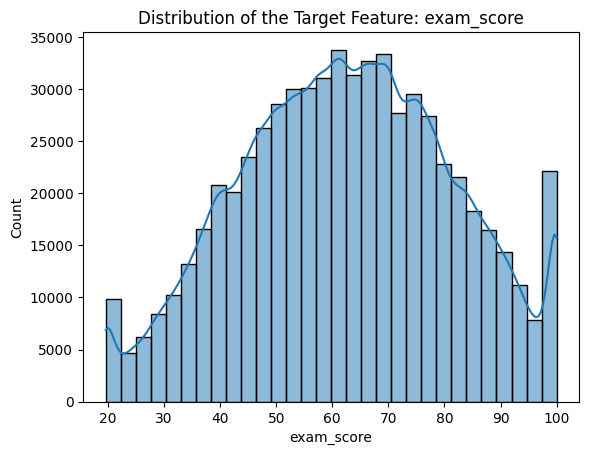

In [18]:
sns.histplot(train_df["exam_score"], bins=30, kde=True)
plt.title("Distribution of the Target Feature: exam_score")
plt.show()

In [19]:
train_df["age"].value_counts()

age
21    86620
23    82872
20    80742
19    78885
24    77111
18    75632
22    74950
17    73188
Name: count, dtype: int64

In [20]:
print(cat_cols)

['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


In [21]:
train_df["gender"].value_counts().sort_values(ascending=False)

gender
other     211097
male      210593
female    208310
Name: count, dtype: int64

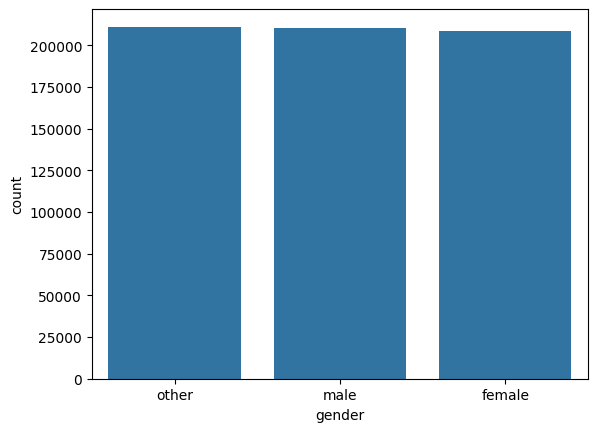

In [22]:
sns.countplot(data=train_df, x="gender",order=train_df["gender"].value_counts().sort_values(ascending=False).index)
plt.show()

In [23]:
train_df["course"].value_counts().sort_values(ascending=False)

course
b.tech     131236
b.sc       111554
b.com      110932
bca         88721
bba         75644
ba          61989
diploma     49924
Name: count, dtype: int64

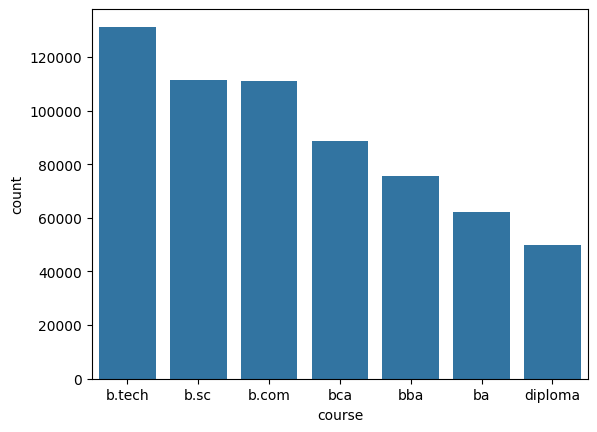

In [24]:
sns.countplot(data=train_df, x="course", order=train_df["course"].value_counts().sort_values(ascending=False).index)
plt.show()

In [25]:
train_df["internet_access"].value_counts().sort_values(ascending=False)

internet_access
yes    579423
no      50577
Name: count, dtype: int64

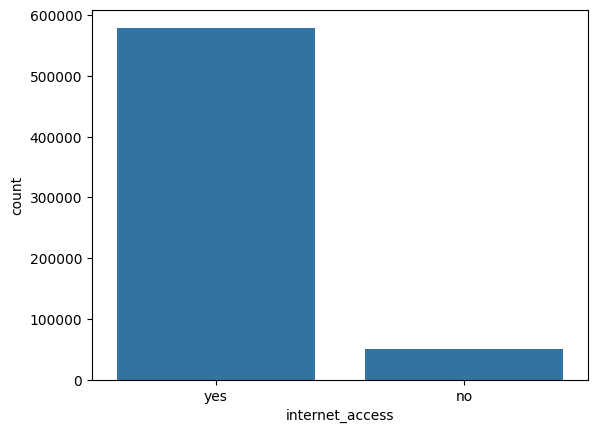

In [26]:
sns.countplot(data=train_df, x="internet_access", order=train_df["internet_access"].value_counts().sort_values(ascending=False).index)
plt.show()

In [27]:
train_df["sleep_quality"].value_counts().sort_values(ascending=False)

sleep_quality
poor       213675
good       213089
average    203236
Name: count, dtype: int64

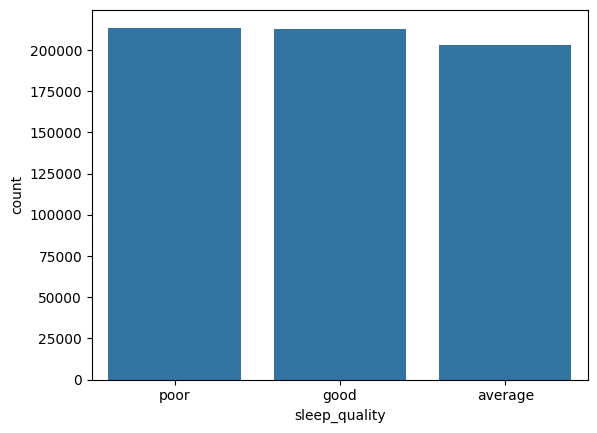

In [28]:
sns.countplot(data=train_df, x="sleep_quality", order=train_df["sleep_quality"].value_counts().sort_values(ascending=False).index)
plt.show()

In [29]:
train_df["study_method"].value_counts().sort_values(ascending=False)

study_method
coaching         131697
self-study       131131
mixed            123086
group study      123009
online videos    121077
Name: count, dtype: int64

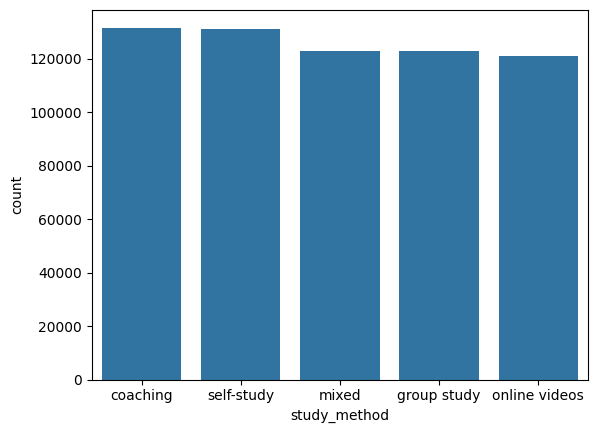

In [30]:
sns.countplot(data=train_df, x="study_method", order=train_df["study_method"].value_counts().sort_values(ascending=False).index)
plt.show()

In [31]:
train_df["facility_rating"].value_counts().sort_values(ascending=False)

facility_rating
medium    214082
low       212378
high      203540
Name: count, dtype: int64

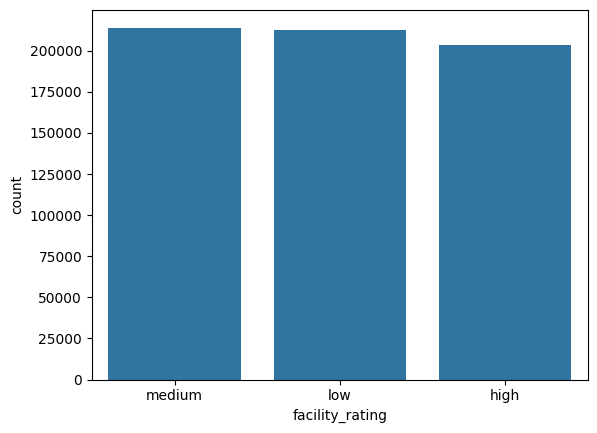

In [32]:
sns.countplot(data=train_df, x="facility_rating", order=train_df["facility_rating"].value_counts().sort_values(ascending=False).index)
plt.show()

In [33]:
train_df['exam_difficulty'].value_counts().sort_values(ascending=False)

exam_difficulty
moderate    353982
easy        176540
hard         99478
Name: count, dtype: int64

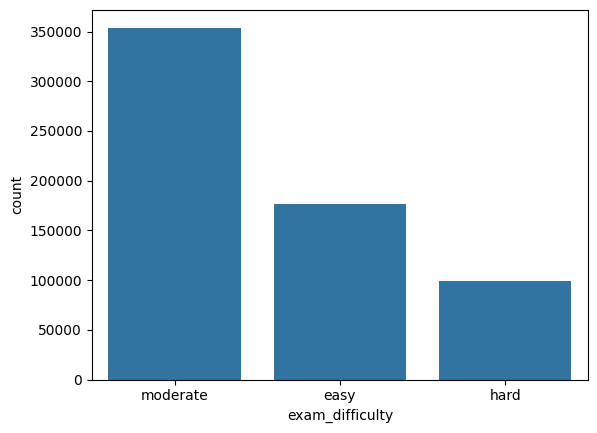

In [34]:
sns.countplot(data=train_df, x='exam_difficulty', order=train_df['exam_difficulty'].value_counts().sort_values(ascending=False).index)
plt.show()

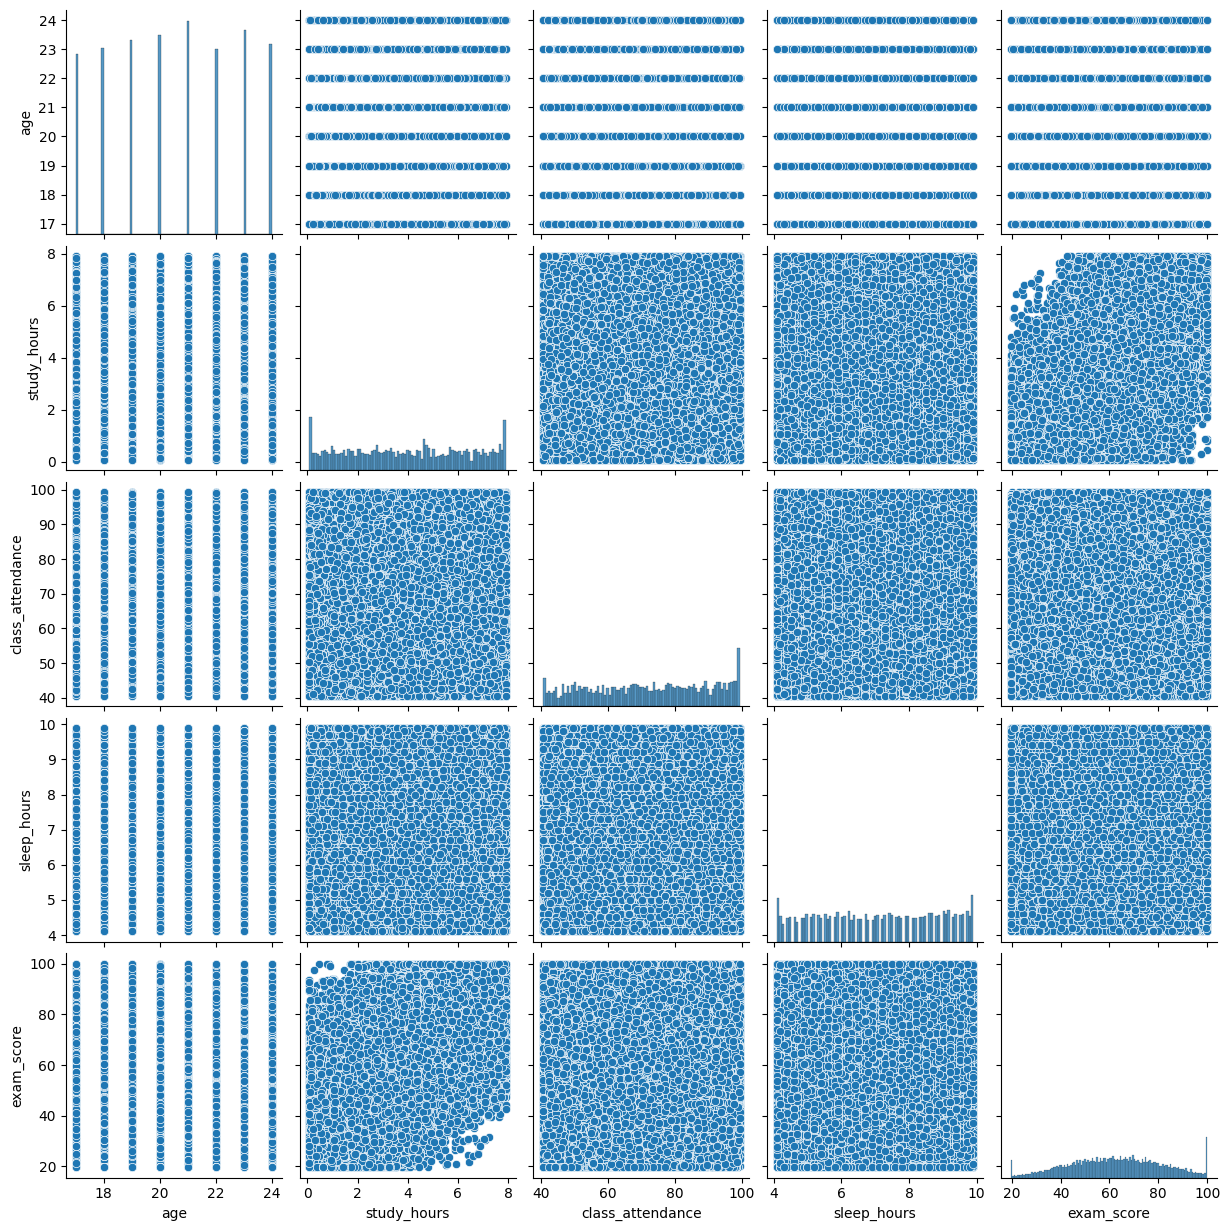

In [35]:
sns.pairplot(train_df[num_cols])
plt.show()

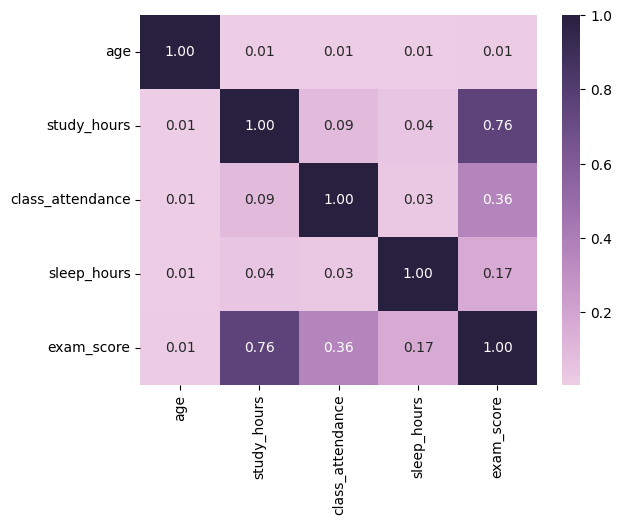

In [36]:
sns.heatmap(train_df[num_cols].corr(), annot=True, fmt='.2f', cmap=sns.cubehelix_palette(rot=.2, as_cmap=True))
plt.show()

* **Correlation between age/exam_score**: very low almost no correalation at all.
* **Correlation between class_attendance/exam_score and sleep_hours/exam_score**: somehow correlated.
* **Correlation between study_hours/exam_score**: there's a high correlation between the two features.

# 6. Data Preprocessing 

In [37]:
train_df.drop(columns=["age", "exam_difficulty"], inplace=True)
test_df.drop(columns=["age", "exam_difficulty"], inplace=True)

In [38]:
# ord_features=['sleep_quality', 'facility_rating', 'exam_difficulty']
nom_features=['course', 'gender', 'internet_access', 'study_method']
ord_features=['sleep_quality', 'facility_rating']


In [39]:
sleep_order=["poor", "average", "good"]
facility_order=["low", "medium", "high"]
exam_order=["easy", "moderate", "high"]
ord_encoder=OrdinalEncoder(categories=[sleep_order, facility_order], handle_unknown='use_encoded_value', unknown_value=-1 )
train_df[ord_features] = ord_encoder.fit_transform(train_df[ord_features])
test_df[ord_features] = ord_encoder.transform(test_df[ord_features])

In [40]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(train_df[nom_features])

train_encoded = ohe.transform(train_df[nom_features])
train_encoded_df = pd.DataFrame(
    train_encoded,
    columns=ohe.get_feature_names_out(nom_features),
    index=train_df.index
)

train_df = train_df.drop(columns=nom_features)
train_df = pd.concat([train_df, train_encoded_df], axis=1)

In [41]:
test_encoded = ohe.transform(test_df[nom_features])

test_encoded_df = pd.DataFrame(
    test_encoded,
    columns=ohe.get_feature_names_out(nom_features),
    index=test_df.index
)
test_df = test_df.drop(columns=nom_features)
test_df = pd.concat([test_df, test_encoded_df], axis=1)


In [42]:
scaler=StandardScaler()
train_df[num_cols[1:4]]=scaler.fit_transform(train_df[num_cols[1:4]])
test_df[num_cols[1:4]]=scaler.transform(test_df[num_cols[1:4]])

In [43]:
y=train_df["exam_score"]
X=train_df.drop(columns=["exam_score"])

In [44]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=RAND_STATE)

# 7. Modeling

## 7.1 XGBRegressor Model

In [45]:
xgb_model=XGBRegressor(n_estimators=5000,
    learning_rate=0.01,
    eval_metric="rmse",
    random_state=RAND_STATE,
    n_jobs=-1)
xgb_model.fit(X_train, y_train, verbose=100)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [46]:
y_pred = xgb_model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print(f"MSE Score for XGBRegreesor Model: {MSE:.3f}")#76.433

MSE Score for XGBRegreesor Model: 76.433


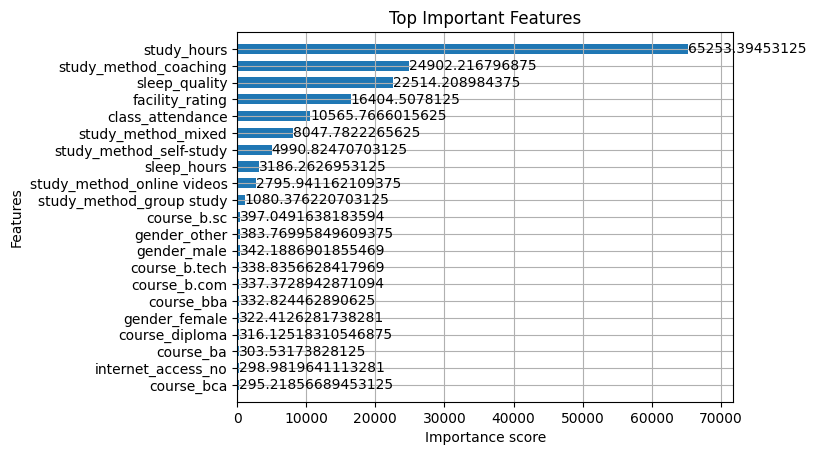

In [47]:
plot_importance(xgb_model, max_num_features=30, importance_type='gain', height=0.6)
plt.title("Top Important Features")
plt.show()

## 7.2 RandomForestRegressor Model

In [48]:
rdf_model=RandomForestRegressor()
rdf_model.fit(X_train, y_train)

RandomForestRegressor()

In [49]:
y_pred = rdf_model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print(f"MSE Score for CatBoostRegressor Model: {MSE:.3f}")#76.401

MSE Score for CatBoostRegressor Model: 83.699


## 7.3 LGBMRegressor Model

In [50]:
lgbm_model=LGBMRegressor()
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 22
[LightGBM] [Info] Start training from score 62.482335


LGBMRegressor()

In [51]:
y_pred = lgbm_model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print(f"MSE Score for LGBMRegressor Model: {MSE:.3f}")#77.435

MSE Score for LGBMRegressor Model: 77.435


## 7.4 CatBoost Model

In [52]:
cat_model=CatBoostRegressor(iterations=3000, learning_rate=0.05, depth=8, loss_function="RMSE")
cat_model.fit(X_train, y_train, verbose=200)

0:	learn: 18.2732221	total: 115ms	remaining: 5m 43s
200:	learn: 8.8116743	total: 10.3s	remaining: 2m 22s
400:	learn: 8.7676881	total: 20.3s	remaining: 2m 11s
600:	learn: 8.7343465	total: 30.5s	remaining: 2m 1s
800:	learn: 8.7061039	total: 40.8s	remaining: 1m 51s
1000:	learn: 8.6807929	total: 50.9s	remaining: 1m 41s
1200:	learn: 8.6563312	total: 1m	remaining: 1m 31s
1400:	learn: 8.6332937	total: 1m 10s	remaining: 1m 20s
1600:	learn: 8.6113959	total: 1m 20s	remaining: 1m 10s
1800:	learn: 8.5901550	total: 1m 30s	remaining: 1m
2000:	learn: 8.5693501	total: 1m 41s	remaining: 50.4s
2200:	learn: 8.5494359	total: 1m 50s	remaining: 40.3s
2400:	learn: 8.5296524	total: 2m 1s	remaining: 30.2s
2600:	learn: 8.5109448	total: 2m 11s	remaining: 20.1s
2800:	learn: 8.4922959	total: 2m 21s	remaining: 10s
2999:	learn: 8.4740999	total: 2m 31s	remaining: 0us


In [53]:
y_pred = cat_model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print(f"MSE Score for CatBoostRegressor Model: {MSE:.3f}")#76.401

MSE Score for CatBoostRegressor Model: 76.401


# 8. Hyperparameter Tuning

In [54]:
# param_grid = {
#     'max_depth': [4, 5, 6, 8],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [2000, 4000, 5000]
# }

In [55]:
# params = {
#     'objective': 'reg:squarederror',
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'n_estimators': 100,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'random_state': 42
# }

In [56]:
# gb_model = XGBRegressor()
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# clf=grid_search.fit(X_train, y_train)


In [57]:
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(0.5))

# 9. Submit Predictions

In [58]:
y_pred = cat_model.predict(test_df.drop(columns=["id"]))

In [59]:
submission = pd.DataFrame({'id': test_df['id'], "exam_score": y_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file saved")
display(submission.head())

Submission file saved


,id,exam_score
0,630000,70.864244
1,630001,70.393586
2,630002,88.644653
3,630003,56.696515
4,630004,48.957973
